# TP2 MVA
##### _Author: Hugo SIMON_

In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from fichiers_utils import plot_train_test_loss,NMSE,correctPerm,My_dataset
import numpy as np
import pickle
from train import train_non_blind ,train_blind
from ISTA_A import ISTA_A
from ISTA_S import ISTA_S
from PALM import PALM

In this partical work, we will implement several source separation algorithms. We will see both classical iterative methods (ISTA, PALM), and learning-based methods (LISTA, LPALM).
For the sake of homogeneity between the algorithms, you will use as much as possible the Pytorch library (even for classical algorithms that could be done will numpy only).

The first step consists in loading the dataset. As usual, we will here consider a training set, with which the learnt model will be trained, and a testing set, with which the models will be tested once learned. Further note that it might be interesting to consider a validation set to settle some hyperparameters (learning rate for instance), but we will not do so for the sake of simplicity.

In machine learning, it is often convenient (if not necessary) to work with mini-batches: that is, instead of working with the whole dataset which might require too much memory, we split it.

Interestingly, Pytorch proposes a module, DataLoader, enabling to easily work will mini-batches. *Use it to obtain a data loader, both for the training set and the testing set.*

If you are not familiar with DataLoader, please have a look at the online documentation.

In [2]:
#%% Dataset 
with open('train_set_TP.pickle', 'rb') as f:
      train_set = pickle.load(f)

with open('test_set_TP.pickle', 'rb') as f:
      val_set = pickle.load(f)

torch.manual_seed(42)
train_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=False)
val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False)

for Xs, As, Ss in train_loader:
    print(f"Xs shape: {Xs.shape}, As shape: {As.shape} , Ss shape: {Ss.shape}")
for Xs_val, As_val, Ss_val in val_loader:
    print(f"Xs_val shape: {Xs_val.shape}, As_val shape: {As_val.shape} , Ss_val shape: {Ss_val.shape}")

Xs shape: torch.Size([150, 65, 500]), As shape: torch.Size([150, 65, 4]) , Ss shape: torch.Size([150, 4, 500])
Xs_val shape: torch.Size([50, 65, 500]), As_val shape: torch.Size([50, 65, 4]) , Ss_val shape: torch.Size([50, 4, 500])


*QUESTION* : how many samples are there in each data set?  
$\hookrightarrow$ Training set has 150 samples and validation set has 50 samples.

*QUESTION* : what is inside of each sample ?  
X, A and S

To check that you understood correctly how a data loader works, plot below the mixing matrix of the first training sample.

*QUESTION* : what is the impact of the mini-batch size on the size of the matrices you consider ?  
$\hookrightarrow$ It is the size of the first axis.

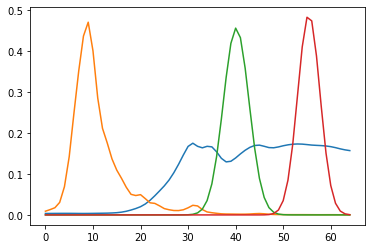

In [3]:
A = As[0]
plt.figure(), plt.plot(A);

# Non blind source separation through ISTA

In this part, we will first start by performing **non-blind** source separation by implementing an ISTA algorithm to estimate S.

*Question* : first recall the cost function we want to minimize to perform non-blind sparse source separation.

$\hookrightarrow$ We minimize
$$\min_S \mathcal L(S) = \min_S \frac 1 2 \rVert X - AS \rVert^2 + \lambda \lVert S \rVert_1$$

To minimize this cost function, we will use the proximal operator of the L_1 norm. 

*Question* : recall the expression of such an operator.  

$\hookrightarrow$ $\operatorname{prox}_{\gamma \rVert \cdot \rVert_1} = \mathcal S_{\gamma} $
where $ \mathcal S_{\gamma}$ is the soft-thresholding function of margin $\gamma$

Implement such a proximal operator and check that you obtain the expected results on simple examples.

In [4]:
def prox_l1(x,thrd=0):
    # Input : 
    # x : a torch tensor
    # thrd : a float
    zerolike = torch.zeros_like(x)
    return torch.maximum(zerolike,x-thrd) + torch.minimum(zerolike,x+thrd)

*Question* : to implement the ISTA algorithm to recover S, you also need to compute the gradient of the data-fidelity term. Do the calculations and give the expression.

$\hookrightarrow$ $S_{k+1} = \operatorname{prox}_{\gamma \lambda \rVert \cdot \rVert_1}\left( S_k - \gamma \nabla_S \left[ \frac 1 2 \rVert X - AS_k \rVert^2 \right] \right) = \mathcal S_{\gamma \lambda} (S_k - \gamma A^\top(A S_k - X))$


Now you are ready to **implement the ISTA algorithm**. Do it in the ISTA_S file and then run the code on the test set.

Please note that for the sake of coherence with the following, the expected input of ISTA_S is a data loader. As such, your code must be able to deal with mini-batches.

A tip : 
- to cast a torch tensor A into numpy, you can use A.detach().numpy() (detach enables to detach an object from torch gradient tree)
- to cast a numpy matrix A into pytorch, you can use torch.from_numpy()

In [5]:
%autoreload
S_est_list, itmax_list = ISTA_S(val_loader, lamb = 0.02, itmax = 10000)

Plot the ground truth sources of the first sample of the test set. Do the same for the estimated sources. What do you observe ?

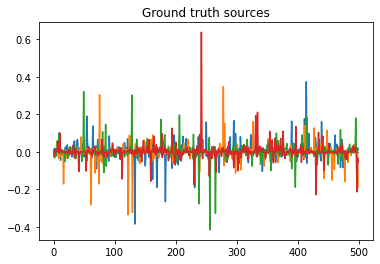

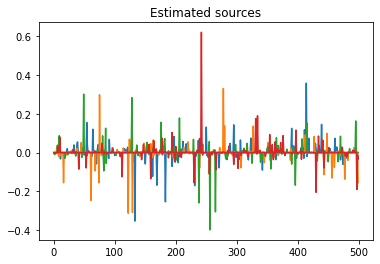

In [6]:
plt.figure(),plt.plot(next(iter(val_loader))[2][0].detach().numpy().T)
plt.title('Ground truth sources')
plt.figure(),plt.plot(S_est_list[0][0].detach().numpy().T)
plt.title('Estimated sources');

To make things slightly more interpretable, we will compute accuracy metrics. Precisely, we will here compute the normalized NMSE of the estimated sources and the ground truth sources.

For each sample, compute such an NMSE. Evaluate the median NMSE over the whole test set.

In [7]:
nmseTabS = [] # An object containing the NMSE for all the sources
mse = torch.nn.MSELoss()
for _, _, S in val_loader:
    for s, s_est in zip(S, S_est_list[0]):
        zerolike = torch.zeros_like(s)
        nmseTabS.append( mse(s_est, s) / mse(zerolike, s))

In [8]:
print(np.median(nmseTabS)) # Print median NMSE over the sources

0.07392145482517139


*BONUS* : if you have time, implement a FISTA algorihtm to find S. Compare your results, and in particular the required number of ierations for obtaining a given value of the cost function, with the ones of ISTA.

# Source separation through LISTA

We will now try to tackle the source separation problem using the LISTA algorithm to estimate S.

*Question* : shortly recall the principle of algorithm unrolling and of LISTA. Recall the form of LISTA update. What are the pros and cons of performing unrolling?


$\hookrightarrow$ The iterative algorithms write in the form of a loop refining at each step the solution. Algorithm unrolling rewrites this scheme in the form of a neural network, thus the algorithms parameters becomes trainable on a training set. The number of iterations T is usually much smaller than in the original algorithm but unrolling requires a training data base.

LISTA update is then
$$\boxed{S_{k+1} = \mathcal S_{\theta} (W X + G S_k )}$$


The architecture of the code is the following :
- the LISTA file is containing the learnt model (here, LISTA)
- the train file is used to train the parameters of the model. For the moment, you will only focus on the train_non_blind function, which will be used to train your LISTA model.

You must complete both files and generate from them a trained LISTA model.

The train_non_blind uses the following arguments :

train_total_loss, val_total_loss,model = train_non_blind(train_loader, test_loader, num_epochs=100, lr=0.0001, T=10, alpha = 10, theta_shared=True,We_shared=True,G_shared=True,optSave=True)
   
Inputs :
- train_loader and test_loader are data loaders for the training and testing sets, respectilvely. Although test_loader is not strictly speaking required, it can be used to check if the parameters you use are relevant (to check if you have over- or under-fitting) ? Note that in principle, a validation test should rather be used, but again we will use the testing set for simplicity.

- num_epochs is the number of epochs that you will use to train the model. Start low and increase later.

- lr is the learning rate for the Adam algorithm.

- T is the number of layers of the unrolled algorithm

- alpha is the initialization of the threshold

- theta_shared, We_shared, G_shared: indicates whether the corresponding matrix is shared over the layers.

- optSave : save the model at each epoch. This is recommanded to check bugs, perform early stopping and so on.


Outputs :
- train_total_loss : train loss value at each epoch.
- val_total_loss : validation loss value at each epoch.

*Question* : recall what shared parameters means.

The LISTA model requires the following parameters :
LISTA(T=16, alpha=5, A=None,theta_shared=True ,We_shared = True ,G_shared = True)

Inputs :
- T : number of layers
- alpha : initial threshold value
- A : used for the initialization of the W_e and G matrices
- theta_shared=True ,We_shared = True ,G_shared = True : indicates whether the corresponding matrices are shared among the layers

Outputs :
- S : predicted sources

Evaluation

epoch:0 | training loss:0.38575 | validation loss:0.37980 
Evaluation
epoch:1 | training loss:0.32204 | validation loss:0.34112 
Evaluation
epoch:2 | training loss:0.29272 | validation loss:0.31674 
Evaluation
epoch:3 | training loss:0.27260 | validation loss:0.29868 
Evaluation
epoch:4 | training loss:0.25643 | validation loss:0.28329 
Evaluation

epoch:5 | training loss:0.24209 | validation loss:0.26926 
Evaluation
epoch:6 | training loss:0.22884 | validation loss:0.25619 
Evaluation
epoch:7 | training loss:0.21640 | validation loss:0.24380 
Evaluation
epoch:8 | training loss:0.20466 | validation loss:0.23197 
Evaluation
epoch:9 | training loss:0.19356 | validation loss:0.22030 
Evaluation

epoch:10 | training loss:0.18270 | validation loss:0.20834 
Evaluation
epoch:11 | training loss:0.17248 | validation loss:0.19701 
Evaluation
epoch:12 | training loss:0.16347 | validation loss:0.18698 
Evaluation
epoch:13 | training loss:0.15609 | validation loss:0.17880 
Evaluation
ep

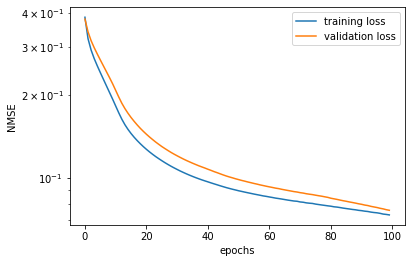

In [17]:
batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False)
train_total_loss, test_total_loss, model = train_non_blind(train_loader, val_loader, lr = 0.0001, num_epochs=100, T= 25 , alpha = 1e-5,theta_shared=False,We_shared=False,G_shared=False,optSave=False)
plot_train_test_loss(train_total_loss,test_total_loss)
# model = torch.load('LISTA_epoch_99.pth')

Now, predict the sources on the testing set, and plot one of them.

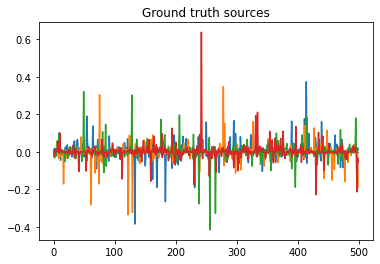

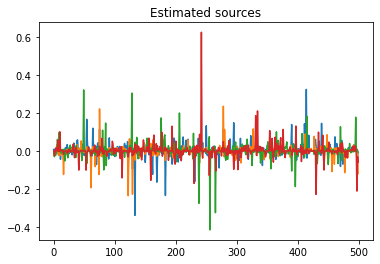

In [20]:
model.eval()
for i, (X, _, S) in enumerate(val_loader):
    S_pred_list = model(X).detach()

plt.figure(),plt.plot(next(iter(val_loader))[2][0].detach().numpy().T)
plt.title('Ground truth sources')
plt.figure(),plt.plot(S_pred_list[0].numpy().T)
plt.title('Estimated sources');

As above, compute the normalized NMSE of the estimated sources and the ground truth sources.

For each sample, compute such an NMSE. Evaluate the median NMSE over the whole test set.

In [22]:
nmseTabS = [] # An object containing the NMSE for all the sources
mse = torch.nn.MSELoss()
for _, _, S in val_loader:
    for s, s_est in zip(S, S_pred_list):
        zerolike = torch.zeros_like(s)
        nmseTabS.append( (mse(s_est, s) / mse(zerolike, s)).numpy() )
print(np.median(nmseTabS)) # Print median NMSE over the sources

0.0693710264398019


Trying to visuality evaluate the sources is not easy in our case, since they correspond to generalized gaussians. 

Implement an ISTA algorithm to recover, both from the mixtures samples X and LISTA estimate of S, the mixing matrices A. To do that, fill the ISTA_A file.

In [23]:
A_est, itTab = ISTA_A(val_loader,S_pred_list,10000)

Plot a ground truth mixing matrix and the corresponding estimated one. Compute the NMSE over the estimated mixing matrices.

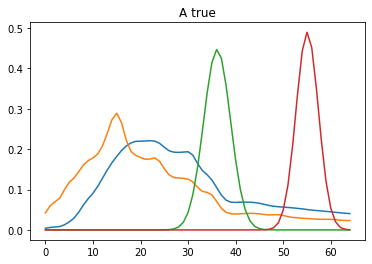

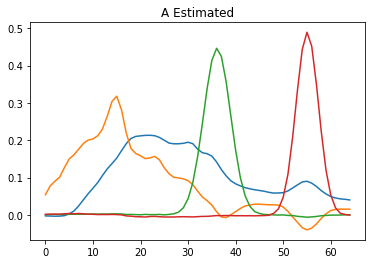

In [24]:
kplotted = 0
plt.figure(),plt.plot(next(iter(val_loader))[1][kplotted].detach().numpy())
plt.title('A true')
plt.figure(),plt.plot(A_est[0][kplotted].numpy())
plt.title('A Estimated');

In [25]:
#%% Metric computation
nmseTabA = [] # An object containing the NMSE for all the mixing matrices
mse = torch.nn.MSELoss()
for _, A, _ in val_loader:
    for a, a_est in zip(A, A_est[0]):
        zerolike = torch.zeros_like(a)
        nmseTabA.append( (mse(a_est, a) / mse(zerolike, a)).numpy() )
print(np.median(nmseTabA)) # Print median NMSE over the mixing matrices

0.022177826757848147


*BONUS* : try to redo the same experiments but with a fixed A over all the data sets? Does it improve LISTA results?

*BONUS* : use non-shared parameters. What do you observe?  
$\hookrightarrow$ performances are slightly better, but training runs slower.

*BONUS* : change the mini-batch size and the learning rate. What do you observe?  
$\hookrightarrow$ reducing batch size yields more gradient steps but noiser. In this case, gradient estimation doesn't seem very noisy so a small batch size yields faster convergence.

# Blind source separation using PALM

Although LISTA is not estimating the mixing matrix A directly, we above performed *blind* source separation, by using LISTA for estimating S, and then combining it with an ISTA for estimating A.

We will now compare the results we obtained above with two algorithms that are designed to directly tackle blind problem: PALM and its learnt counterpart, LPALM.

First, implement the PALM algorithm we saw in class, in the PALM file. Launch it on the test set.

*Question* : what can of initialization can you use for A for the PALM algorithm?

In [27]:
Ainit = 0.01+torch.rand((65,4), dtype=torch.double)
A_est_list,S_est_list,itmax_list = PALM(val_loader, lamb = 0.02, itmax = 10000,Ainit=Ainit)

example %d 0
itmax 357
itmax 434
itmax 133
itmax 659
itmax 118
itmax 261
itmax 205
itmax 186
itmax 49
itmax 323
itmax 967
itmax 536
itmax 131
itmax 120
itmax 4302
itmax 141
itmax 75
itmax 64
itmax 71
itmax 150
itmax 1115
itmax 107
itmax 630
itmax 138
itmax 278
itmax 522
itmax 186
itmax 104
itmax 116
itmax 115
itmax 43
itmax 83
itmax 106
itmax 93
itmax 123
itmax 564
itmax 157
itmax 112
itmax 55
itmax 334
itmax 102
itmax 184
itmax 95
itmax 259
itmax 67
itmax 34
itmax 771
itmax 93
itmax 264
itmax 1438


Plot below a mixing matrix of the test set and its estimate by PALM.

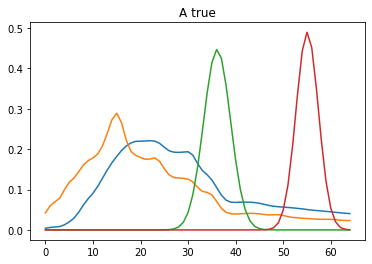

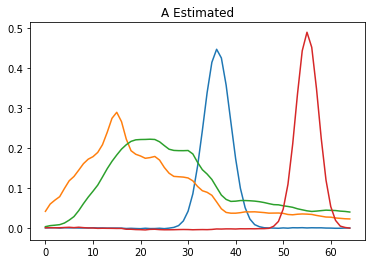

In [28]:
kplotted = 0
plt.figure(),plt.plot(next(iter(val_loader))[1][kplotted].detach().numpy())
plt.title('A true')
plt.figure(),plt.plot(A_est_list[0][kplotted].numpy())
plt.title('A Estimated');

For each sample, compute such the NMSE of the estimated sources and the ground truth sources. Evaluate the median NMSE over the whole test set.

Pay attention to the fact that there is a permutation ambiguity in *blind* source separation algorithms. Therefore, you might find the following fundtion helpful (no need to change anything inside of the function) :

A_cor,ind = correctPerm(A_np,A_est_np)

Inputs :
- A_np : a ground truth mixing matrix (numpy array)
- A_est_np : an estimated mixing matrix (numpy array)

Outputs :
- A_cor : A_np with permutated columns such that A_cor is the closest
- ind : permutation inidices such that A_est_np[:,ind] is the closest to A_np

In [29]:
#%% Metric computation
nmseTabS = [] # An object containing the NMSE for all the sources
mse = torch.nn.MSELoss()
for _, A, S in val_loader:
    for s, s_est, a, a_est in zip(S, S_est_list[0], A, A_est_list[0]):
        nmse = NMSE(a.numpy(), a_est.numpy(), s.numpy(), s_est.numpy())
        nmseTabS.append( nmse )
print(np.median(nmseTabS)) # Print median NMSE over the sources

0.07916098727339069


*Question*: what do you conclude about the above results? Further compare with LISTA output.

$\hookrightarrow$ We obtain a little worse NMSE score than before but in this case we did not know mixing matrices. We have to compare methods on solving the same problem (NBSS before, BSS now).

# Unrolling the PALM algorithm: LPALM

The last part of this practical work consists in unrolling the PALM algorithm. The principle is similar to the one of LISTA. Nevertheless, the training is slightly longer. Therefore, you are also provided with an already trained model, so that you can perform preliminary tests prior to having fully trained your own model.

Similarly to what you did with LISTA, implement the LPALM algorithm. To do that, fill the train_blind function of the train file and the LPALM file. You can then run the following line of code, and play with its parameters.

In [3]:
train_total_loss, test_total_loss, model = train_blind(train_loader, val_loader, num_epochs=100, T=25, lr = 0.0001,
                                                       theta_shared=True, W_CP_S_shared=True, L_A_shared=True, 
                                                       optSave=False,folderInitSave='150rand')
plt.figure(),plot_train_test_loss(train_total_loss,test_total_loss);

Epoch 0
Epoch-0 lr: 0.0001

epoch:0 | training loss:42.17747 | validation loss:33.63160 
Epoch 1
Epoch-1 lr: 0.0001
epoch:1 | training loss:41.57673 | validation loss:32.56770 
Epoch 2
Epoch-2 lr: 0.0001
epoch:2 | training loss:40.98709 | validation loss:31.80114 
Epoch 3
Epoch-3 lr: 0.0001
epoch:3 | training loss:40.40861 | validation loss:31.09597 
Epoch 4


KeyboardInterrupt: 

In [5]:
model = torch.load('LPALM_epoch_99.pth')

Below, compute the results of LPALM on the test set. Prior the end of the training of you model, you can load the model below.

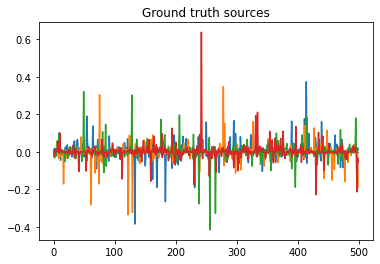

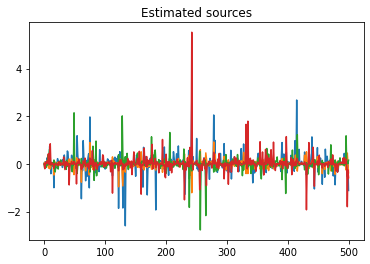

In [6]:
model.eval()
with torch.no_grad():
    for i, (X, _, _) in enumerate(val_loader):
        S_pred_list, A_pred_list = model(X)

plt.figure(),plt.plot(next(iter(val_loader))[2][0].detach().numpy().T)
plt.title('Ground truth sources')
plt.figure(),plt.plot(S_pred_list[0].numpy().T)
plt.title('Estimated sources');

Compute the quality metrics and conclude.

In [7]:
#%% Metric computation
nmseTabS = [] # An object containing the NMSE for all the sources
nmseTabA = [] # An object containing the NMSE for all the mixing matrices

mse = torch.nn.MSELoss()
for _, A, S in val_loader:
    for s, s_est in zip(S, S_pred_list):
        zerolike = torch.zeros_like(s)
        nmseTabS.append( (mse(s_est, s) / mse(zerolike, s)).numpy() )
    print(f"Sources NMSE: {np.median(nmseTabS)}") # Print median NMSE over the sources
    for a, a_est in zip(A, A_pred_list):
        zerolike = torch.zeros_like(a)
        nmseTabA.append( (mse(a_est, a) / mse(zerolike, a)).numpy() )
    print(f"Mixing NMSE: {np.median(nmseTabA)}") # Print median NMSE over the mixing matrices

Sources NMSE: 29.02116551875964
Mixing NMSE: 0.8828113490923921


In [8]:
#%% Metric computation
nmseTabS = [] # An object containing the NMSE for all the sources
mse = torch.nn.MSELoss()
for _, A, S in val_loader:
    for s, s_est, a, a_est in zip(S, S_pred_list, A, A_pred_list):
        nmse = NMSE(a.numpy(), a_est.numpy(), s.numpy(), s_est.numpy())
        nmseTabS.append( nmse )
print(f"Trying to solve for potential permutations, \nSources NMSE: {np.median(nmseTabS)}") # Print median NMSE over the sources

Trying to solve for potential permutations, 
Sources NMSE: 29.309262087478483
